# IMDb Exploratory Data Analysis Example

This notebook is playground for messing around with the [IMDB dataset](https://www.imdb.com/interfaces/)

## Setting Up

First, let's import all the required Python modules, and configure some CSS styles:

In [1]:
import pandas as pd
import pyvis as pv
import seaborn as sns

In [2]:
%%html
<style>
  table {margin-left: 0 !important}
  iframe {width: 100% !important}
</style>

## Loading IMDb Dataset

Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. The available datasets are as follows: 

### title.akas.tsv.gz

Contains the following information for titles:

| Name | Type | Description |
| ---- | ---- | ----------- |
|titleId | string | a tconst, an alphanumeric unique identifier of the title|
|ordering | integer | a number to uniquely identify rows for a given titleId|
|title | string | the localized title|
|region | string | the region for this version of the title|
|language | string | the language of the title|
|types | array | Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning|
|attributes | array | Additional terms to describe this alternative title, not enumerated|
|isOriginalTitle | boolean | 0: not original title; 1: original title|

In [3]:
title_akas = pd.read_csv('data/title.akas.tsv.gz', sep='\t', na_values='\\N')

### title.basics.tsv.gz

Contains the following information for titles:

| Name | Type | Description |
|------|------|-------------|
|tconst | string | alphanumeric unique identifier of the title|
|titleType | string | the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)|
|primaryTitle | string | the more popular title / the title used by the filmmakers on promotional materials at the point of release|
|originalTitle | string | original title, in the original language|
|isAdult | boolean | 0: non-adult title; 1: adult title|
|startYear | string | YYYY - represents the release year of a title. In the case of TV Series, it is the series start year|
|endYear | string | YYYY - TV Series end year. ‘\N’ for all other title types|
|runtimeMinutes | int | primary runtime of the title, in minutes|
|genres | string array | includes up to three genres associated with the title|


In [4]:
title_basics = pd.read_csv(
    'data/title.basics.tsv.gz', sep='\t', na_values='\\N', low_memory=False).set_index('tconst')

### title.crew.tsv.gz

Contains the director and writer information for all the titles in IMDb. Fields include:

| Name | Type | Description |
|------|------|-------------|
|tconst | string | alphanumeric unique identifier of the title|
|directors | array of nconsts | director(s) of the given title|
|writers | array of nconsts | writer(s) of the given title|

In [5]:
title_crew = pd.read_csv('data/title.crew.tsv.gz', sep='\t', na_values='\\N')

### title.episode.tsv.gz

Contains the tv episode information. Fields include:

| Name | Type | Description |
|------|------|-------------|
|tconst | string | alphanumeric identifier of episode|
|parentTconst | string | alphanumeric identifier of the parent TV Series|
|seasonNumber | integer | season number the episode belongs to|
|episodeNumber | integer | episode number of the tconst in the TV series|

In [6]:
title_episode = pd.read_csv('data/title.episode.tsv.gz', sep='\t', na_values='\\N')

### title.principals.tsv.gz

Contains the principal cast/crew for titles:

| Name | Type | Description |
|------|------|-------------|
|tconst |string | alphanumeric unique identifier of the title|
|ordering | integer | a number to uniquely identify rows for a given titleId|
| nconst | string | alphanumeric unique identifier of the name/person |
| category | string | person's role: actor, producer, director, etc. |
|job|string|person's main job|
|characters|list|characters a person has played|

In [7]:
title_principals = pd.read_csv('data/title.principals.tsv.gz', sep='\t', na_values='\\N')

### title.ratings.tsv.gz

Contains the IMDb rating and votes information for titles:

| Name | Type | Description |
|------|------|-------------|
|tconst | string | alphanumeric unique identifier of the title|
|averageRating | double | weighted average of all the individual user ratings|
|numVotes | int | number of votes the title has received|

In [8]:
title_ratings = pd.read_csv('data/title.ratings.tsv.gz', sep='\t', na_values='\\N').set_index('tconst')

### name.basics.tsv.gz

Contains the following information for names:

| Name | Type | Description |
|------|------|-------------|
| nconst | string | alphanumeric unique identifier of the name/person |
| primaryName | string | name by which the person is most often credited |
| birthYear | string | in YYYY format |
| deathYear | string | in YYYY format if applicable, else ‘\N’ |
| primaryProfession | array of strings | the top-3 professions of the person |
| knownForTitles | array of tconsts | titles the person is known for |

In [9]:
name_basics = pd.read_csv('data/name.basics.tsv.gz', sep='\t', na_values='\\N').set_index('nconst')

## Actors of Popular Movies

Let's find out what actors played in more most popular movies.

First, find top N movies in terms of number of votes and rating:

In [10]:
top = title_ratings.merge(
    title_basics[title_basics.titleType.isin(['movie'])], on='tconst').nlargest(
        100, ['numVotes', 'averageRating'])

Find actors who played in them:

In [11]:
top_w_actors = top.merge(
    title_principals[title_principals.category == 'actor'].merge(
        name_basics, on='nconst'), on='tconst')

Now, sort those actors by the number of movies they appeared in:

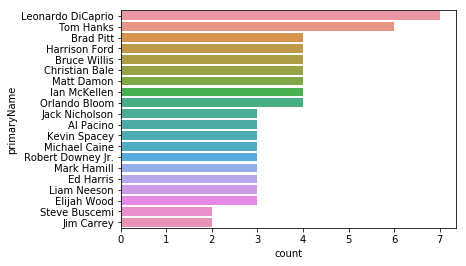

In [12]:
top_in_top = top_w_actors.groupby(['nconst', 'primaryName']).size().reset_index(
    name='count').set_index('nconst').nlargest(20, ['count'])
_ = sns.barplot(x='count', y='primaryName', data=top_in_top)

Visualize top movies / actors using pyvis library:

In [13]:
g = pv.network.Network(height='960px', width='960px', notebook=True)

for _, row in top_w_actors.merge(top_in_top, on='nconst').iterrows():
    title='{0} ({1})'.format(row['primaryTitle'], row['averageRating'])
    g.add_node(row['tconst'], label=title, title=title, value=1)
    g.add_node(row['nconst'], label=row['primaryName_x'], title=row['primaryName_x'],
               color='lightgreen', value=row['count'])
    g.add_edge(row['nconst'], row['tconst'])

g.show('pyvis_out/top_tvseries_actors.html')

## Corelations

Fidn out whether there's a correlation between runtime and rating:

/home/michael/Dev/projects/imdb-eda/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


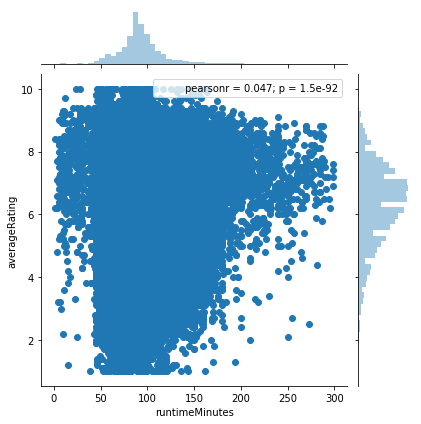

In [37]:
data = title_basics[title_basics.titleType == 'movie'].merge(title_ratings, on='tconst')

data['runtimeMinutes'] = data['runtimeMinutes'].apply(float)
data['averageRating'] = data['averageRating'].apply(float)

_ = sns.jointplot(x='runtimeMinutes', y='averageRating', dropna=True, data=data[data.runtimeMinutes < 300])

As we can see no correlation is found.